## Is it a pothole?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "pothole photos"
1. Use DuckDuckGo to search for images of "road photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a pothole and see if it works.

## Step 1: Download images of potholes and non-potholes

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max_images)
    return L(results).itemgot('image')

Let's start by searching for a pothole photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('pothole street photos', max_images=1)
urls[0]

Searching for 'pothole street photos'


'https://thumbs.dreamstime.com/z/large-pothole-montreal-street-canada-winter-141990589.jpg'

...and then download a URL and take a look at it:

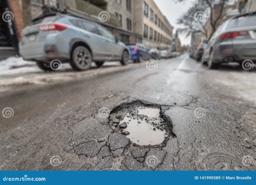

In [5]:
from fastdownload import download_url
dest = 'pothole.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "road photos":

Searching for 'road photos'


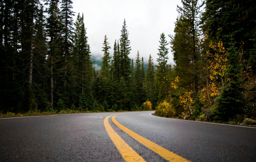

In [6]:
download_url(search_images('road photos', max_images=1)[0], 'road.jpg', show_progress=False)
Image.open('road.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "pothole" and "road" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'road','pothole'
path = Path('pothole_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'road photo'
Searching for 'road sun photo'
Searching for 'road shade photo'
Searching for 'pothole photo'
Searching for 'pothole sun photo'
Searching for 'pothole shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

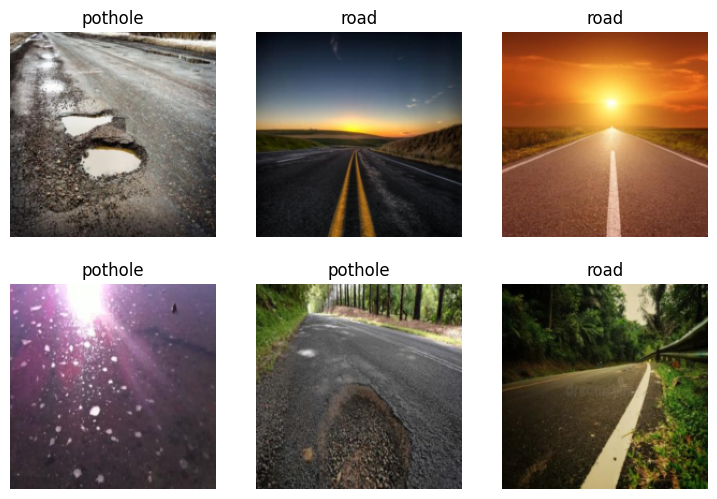

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "pothole" or "road").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *pothole* or *road*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.181091,0.542323,0.187500,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.391510,0.345931,0.125000,00:01
1,0.247361,0.285103,0.125000,00:00
2,0.168097,0.212410,0.062500,00:00


## Step 3: Using the Model

Let's see what our model thinks about that bird we downloaded at the start:

This is a: pothole.
Probability it's a pothole: 0.6983


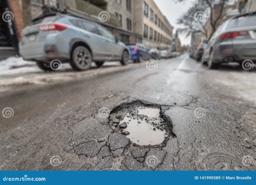

In [11]:
is_pothole,_,probs = learn.predict(PILImage.create('pothole.jpg'))
print(f"This is a: {is_pothole}.")
print(f"Probability it's a pothole: {probs[0]:.4f}")

Image.open('pothole.jpg').to_thumb(256,256)

This is a: road.
Probability it's a pothole: 0.0342


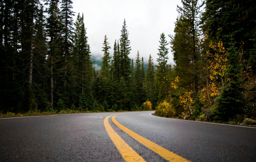

In [12]:
is_pothole,_,probs = learn.predict(PILImage.create('road.jpg'))
print(f"This is a: {is_pothole}.")
print(f"Probability it's a pothole: {probs[0]:.4f}")

Image.open('road.jpg').to_thumb(256,256)